<a href="https://colab.research.google.com/github/niteshctrl/stackoverflow-tags/blob/master/StackOverflow_Tags_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STACKOVERFLOW TAGS PEDICTION
# Table of Contents

0. [Introduction](#section0)
1. [Data Set Up](#section1)
2. [Data Cleaning - I](#section2)
3. [Exploratory Data Analysis](#section3)
4. [Data Cleaning - II and Preprocessing](#section4)
5. [Model Exploration](#section5)
6. [Results and Conclusion](#section6)

# 0 Introduction

### `Task:`
Predict the tags (a.k.a. keywords, topics, summaries), given only the question text and its title. The dataset contains content from disparate stack exchange sites, containing a mix of both technical and non-technical questions.

### `Evaluation Metric:`
The evaluation metric for this project is Mean F1-Score.  The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision P and recall R. Precision is the ratio of true positives (TP) to all predicted positives (TP + FP). Recall is the ratio of true positives to all actual positives (TP + FN). The F1 score is given by:

> F1=2PR / (P + R)

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

The tag predicted must be an exact match, regardless of whether the tags are synonyms. 

* **Why aren't synonyms counted?**

1. Giving out a list of candidate synonyms is a potential source of leakage
2. Synonyms are subjective, and there are "subjectively many" synonyms for a given tag
3. Equally penalized for predicting a synonym of a correct tag, so the task can be framed as not only predicting a tag, but also modeling the distribution(s) of potential synonyms

## Data Description:
Train.csv contains 4 columns: Id,Title,Body,Tags

1. Id - Unique identifier for each question
2. Title - The question's title
3. Body - The body of the question
4. Tags - The tags associated with the question (all lowercase, should not contain tabs '\t' or ampersands '&')
---

Ref : https://medium.com/datadriveninvestor/predicting-tags-for-the-questions-in-stack-overflow-29438367261e

<a class="anchor" id="sec"></a>
# 1 Data Set Up

In [ ]:
# Connecting Google Drive

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Installing library for expanding contractions during Preprocessing

!pip install contractions

In [ ]:
# Importing Libraries

import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Preprocessing Libraries
import re
import nltk
import contractions                     # Use pycontractions in future uses
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Featurization Libraries
import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling Libraries
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


# Metrics Libraries
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Downloading Required NLTK data

nltk.download('punkt')          # For Tokenization
nltk.download('stopwords')      # Set of Stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pd.set_option('display.max_colwidth', 80)

In [ ]:
# Extracting the ZIP data files in Google Drive
"""
!unzip /content/gdrive/My\ Drive/datasets/stacko/Train.zip -d /content/gdrive/My\ Drive/datasets/stacko/
!unzip /content/gdrive/My\ Drive/datasets/stacko/Test.zip -d /content/gdrive/My\ Drive/datasets/stacko"""

'\n!unzip /content/gdrive/My\\ Drive/datasets/stacko/Train.zip -d /content/gdrive/My\\ Drive/datasets/stacko/\n!unzip /content/gdrive/My\\ Drive/datasets/stacko/Test.zip -d /content/gdrive/My\\ Drive/datasets/stacko'

In [ ]:
# Loading the data from Google Drive into PANDAS Dataframe

data = pd.read_csv('/content/gdrive/My Drive/datasets/stacko/Train.csv')

# 2 Data Cleaning I

1. Duplicate Removal
2. NULL Values Check
3. Empty String Check

## 2.1 Duplicates Removal

In [ ]:
# View of the DataFrame

data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image without mime type?,"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpe...",php image-processing file-upload upload mime-types
1,2,How can I prevent firefox from closing when I press ctrl-w,"<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain ...",firefox
2,3,R Error Invalid type (list) for variable,"<p>I am import matlab file and construct a data frame, matlab file contains ...",r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply cannot find the answer myself ...",c# url encoding
4,5,How to modify whois contact details?,"<pre><code>function modify(.......)\n{\n $mcontact = file_get_contents( ""ht...",php api file-get-contents


In [ ]:
# Check for duplicates

data[['Title','Body','Tags']].duplicated().value_counts()

False    4206314
True     1827881
dtype: int64

---

> **There are 1827881 'True' values implying 1.8M duplicate rows.**

---
---

In [ ]:
# Duplicate Removal

data_no_dup = data[['Title','Body','Tags']].drop_duplicates(ignore_index=True)
data_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206314 entries, 0 to 4206313
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Title   object
 1   Body    object
 2   Tags    object
dtypes: object(3)
memory usage: 96.3+ MB


---

> **We are now left with only 4206314 (4.2M) rows which is a reduction of ~30% data rows!!**

---
---

## 2.2 NULL Values Removal

In [ ]:
# NULL Value Check

for column in data_no_dup.columns:
    print("NULL Value check for Column '{}' is\n {}\n".format(column, data_no_dup[column].isnull().value_counts()))

NULL Value check for Column 'Title' is
 False    4206314
Name: Title, dtype: int64

NULL Value check for Column 'Body' is
 False    4206314
Name: Body, dtype: int64

NULL Value check for Column 'Tags' is
 False    4206307
True           7
Name: Tags, dtype: int64



---

> **Observe there exists 7 Null Values in 'Tags' column. We will be investigating it further.**

---
---

In [ ]:
# View of rows with Null Values in 'Tags' column

data_no_dup[data_no_dup['Tags'].isnull()]

,Title,Body,Tags
850166,Do we really need NULL?,"<blockquote>\n <p><strong>Possible Duplicate:</strong><br>\n <a href=""http...",NaN
971049,Page cannot be null. Please ensure that this operation is being performed in...,<p>I get this error when i remove dynamically telerik raddock and raddock zo...,NaN
1347475,How do Germans call null,"<p>In german null means 0, so how do they call null (like null reference) ?<...",NaN
1722409,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</p>\n\n<p>Example:</p>\n\n<pre>...",NaN
2241942,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<blockquote>\n <p>And don't tell me...,NaN
2647070,Handle NullObjects,<p>I have done quite a bit of research on best ways to deal with null object...,NaN
3241110,Find all values that are not null and not in another table,<p>I am running into a problem which results in an ORA-01722 error. I have ...,NaN


---

> **Observe that the corresponding title with Tags = NaN contain the word 'NULL' asking for some information that is related to NULL values. We now investigate further if there exists 'NULL' as a tag to some question.**

---
---

In [ ]:
# Checking if Null is a tag

print((data_no_dup['Tags'] == 'Null').value_counts())
print((data_no_dup['Tags'] == 'NULL').value_counts())
print((data_no_dup['Tags'] == 'null').value_counts())
print((data_no_dup['Tags'] == 'none').value_counts())

False    4206314
Name: Tags, dtype: int64
False    4206314
Name: Tags, dtype: int64
False    4206314
Name: Tags, dtype: int64
False    4206314
Name: Tags, dtype: int64


--- 
> **Since none of the tags contain Null as a tag, removing the above seven questions from our data would serve as it's a very small fraction of the entire dataset.**

---
---

In [ ]:
# Removing Rows with NULL value in Tags

data_no_dup = data_no_dup[data_no_dup['Tags'].notnull()]


# Final Check if Null has been removed successfully
print(data_no_dup['Tags'].isnull().value_counts())

False    4206307
Name: Tags, dtype: int64


# 3 Exploratory Data Analysis

1. Univariate Analysis
2. Multivariate Analysis

In [ ]:
data_no_dup.head()

,Title,Body,Tags
0,How to check if an uploaded file is an image without mime type?,"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or anot...",php image-processing file-upload upload mime-types
1,How can I prevent firefox from closing when I press ctrl-w,"<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quit...",firefox
2,R Error Invalid type (list) for variable,"<p>I am import matlab file and construct a data frame, matlab file contains two columns with and...",r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply cannot find the answer myself :( </p>\n\n<p>Basica...",c# url encoding
4,How to modify whois contact details?,"<pre><code>function modify(.......)\n{\n $mcontact = file_get_contents( ""https://test.httpapi.c...",php api file-get-contents


In [ ]:
data_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4206307 entries, 0 to 4206313
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Title   object
 1   Body    object
 2   Tags    object
dtypes: object(3)
memory usage: 128.4+ MB


---
> **Number of rows = 4206307 ( 4.2M)**

---
---

In [ ]:
# Total number of datapoints to consider for sample in all below references

datapoints = 4206307

In [ ]:
# Check a few Title datapoints

for i in range(20):
    print(data_no_dup['Title'].iloc[i])
    print('------------------------------------------------')

How to check if an uploaded file is an image without mime type?
------------------------------------------------
How can I prevent firefox from closing when I press ctrl-w
------------------------------------------------
R Error Invalid type (list) for variable
------------------------------------------------
How do I replace special characters in a URL?
------------------------------------------------
How to modify whois contact details?
------------------------------------------------
setting proxy in active directory environment
------------------------------------------------
How to draw barplot in this way with Coreplot
------------------------------------------------
How to fetch an XML feed using asp.net
------------------------------------------------
.NET library for generating javascript?
------------------------------------------------
SQL Server : procedure call, inline concatenation impossible?
------------------------------------------------
How do commercial obfuscators 

In [ ]:
# Check a few Body datapoints

for i in range(11, 16):
    print(data_no_dup['Body'].iloc[i])
    print("------------------------------------------------")
    print("------------------------------------------------")

<p>This may sound like an odd question, but where can I find a random number generator that works in C or C++ that is not very good?</p>

<p>Context: I'm creating some tree graph plotting software and testing it by using multi-digit random numbers (so each digit becomes a node in the tree). The random number generator I've been using - which is the one that comes with the GNU C++ compiler - gives me a nice spread of values. That's good, but I want to see how the table looks when the numbers clump together and are less homogenous. </p>

<p>Can anyone suggest a random number generator that has been proven to be not-so-random?</p>

<p>(Oh, any anyone who links to xkcd and/or suggests I just return 4 will get sarcasm in response).</p>

------------------------------------------------
------------------------------------------------
<p>how can I move Inbox/Sent/Draft from Mdaemon to postfix?
<br/>
is there any automatic way? </p>

------------------------------------------------
-----------

---
> **It follows that numerals would be of little use in predictions and they will be damaging more than doing good as the population of numerals is very high in Body without significant predictive power. So we will be removing them in preprocessing stage.**

> **C# which is the highest occuring tag has the symbol '#' which should not be ommited during preprocessing as it is the only distinctive element between C# and C. Similarly '+' for C++. And again, '.'  in "asp.net" and ".NET"**

> **Another thing worth noting is that users generally write their keyword of concern in capital letters. Ex - PHP vs php, .NET vs .net, C# vs c#, XML vs xml, R vs r, LaTeX vs latex, CSS vs css, and many more. However, the word 'I' should be ommited in such observations. We can repeat the words in capital letters during featurization to put on more weight to them.**

> **The section """<code.>...<./code>""" could be of immense use in predictions as it contains the code of a programming language and it is enough alone to predict the tag(if programing language) but needs to be tested as it could be noisy too owing to very often large codes containing keywords like 'string', 'return', etc which is common to most of the programming languages.**

TBD: 
* Uppercase Repeatation
* Numeral Removal
* Not tokenize C#
* Remove Code sections(Uncertain)

---
---

## 3.1 Univariate Analysis

In [ ]:
# Calculate number of spaces in each title which will define it's Word Count

title_word_length = []
for i in tqdm(range(datapoints)):
    title_word_length.append(data_no_dup['Title'].iloc[i].count(" ") + 1)

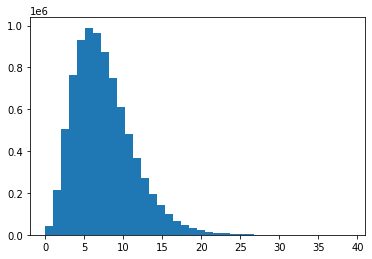

In [ ]:
# Distribution of Title Word length

plt.hist(length_title, bins = 38)
plt.show()

---
> **Most of the titles are in the range of 5-10 words as evident from the distribtion plot. Since, the body is composed of both natural text and programming code, we will skip this analysis on 'Body' as codes could be very lengthly and non-meaningful for analysis**

---
---

In [ ]:
# Number of tags in each row of data

row_tag_count = []
for i in tqdm(range(datapoints)):
    row_tag_count.append(data_no_dup['Tags'].iloc[i].count(" ") + 1)

In [ ]:
pd.Series(row_tag_count).value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
dtype: int64

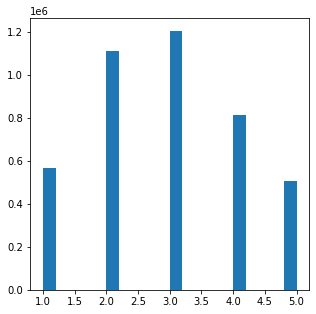

In [ ]:
# Distribution of tag counts in each row

plt.figure(figsize=(5,5))
plt.hist(row_tag_count, bins = 20)
plt.show()

---
> **Minimum number of tag associated to a row is 1 and maximum is 5. Most  of the rows have 3 tags followed by 2 tags and then 4 tags.**

---
---

In [ ]:
# Unique tags and their frequency of occurence

tags = []
for i in data_no_dup['Tags']:
    try:
        tags.extend(i.split())
    except:
        continue

print(pd.Series(tags).value_counts())

c#            331505
java          299414
php           284103
javascript    265423
android       235436
               ...  
mkpolygon          1
chartjs            1
transifex          1
moqcontrib         1
pvpython           1
Length: 42048, dtype: int64


---
> **There are 42048 unique tags in total. Training 42048 models each for a tag will not be an easy task neither scalable too. NOTE: Herefrom, we will be calling c# as Tag 1, java as Tag 2 and so forth in decreasing order of their occurences for ease of plotting.**

---
---

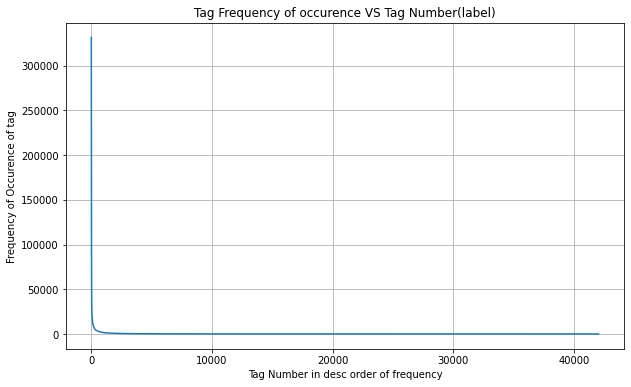

In [ ]:
# Tag Frequency of occurence VS Tag Number(label)

plt.figure(figsize=(10,6))

# Plotting
plt.plot(y)

# Defining Axes
plt.xlabel("Tag Number in desc order of frequency")
plt.ylabel("Frequency of Occurence of tag")

# Defining Title
plt.title("Tag Frequency of occurence VS Tag Number(label)")

plt.grid()
plt.show()

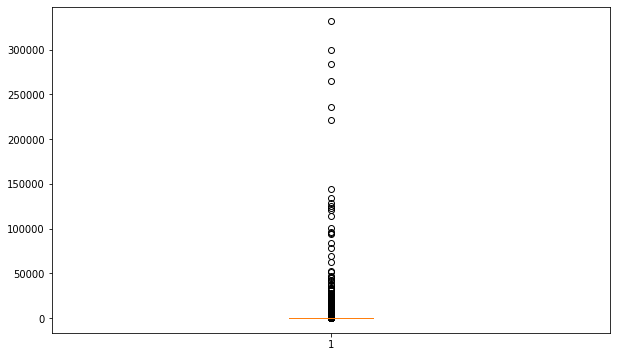

In [ ]:
# Box Plot 

plt.figure(figsize=(10,6))

plt.boxplot(y)
plt.show()

---
> **The above two plots shows highly skewed data i.e. most of the datapoints are covered by a few bunch of Tags whose occurence is quite high. We will investigate further if the less occuring tags can be ommited to reduce the pain of training additional models.**

---
---


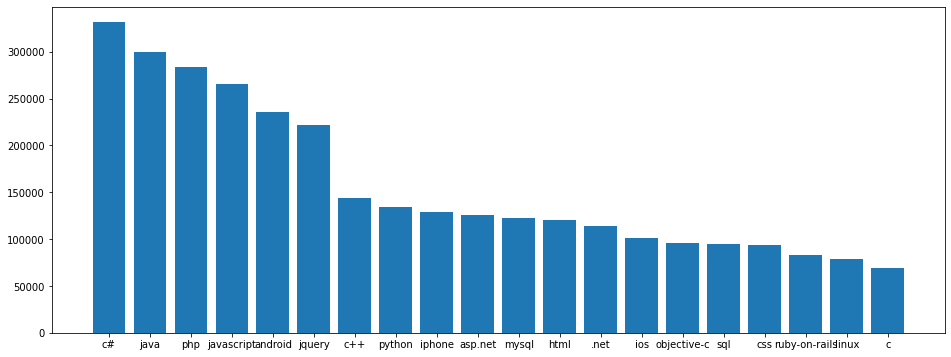

In [ ]:
# Bar Plot of top 20 tags in descending order of occurence

plt.figure(figsize=(16,6))
plt.bar(pd.Series(tags).value_counts().index.values[:20], pd.Series(tags).value_counts()[:20])
plt.show()

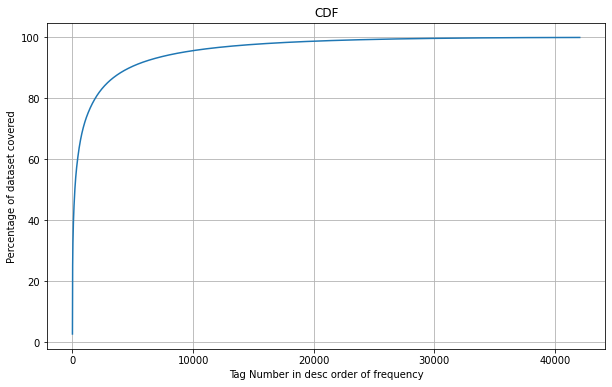

In [ ]:
# CDF of tags

plt.figure(figsize=(10,6))

# Plotting
plt.plot(np.cumsum(y)/12195947*100)

# Defining Title
plt.title('CDF')

#Defing Axes
plt.xlabel('Tag Number in desc order of frequency')
plt.ylabel('Percentage of dataset covered')

plt.grid()
plt.show()

In [ ]:
print("80% of the data is concentrated on {} tags".format(np.where((np.cumsum(y)/12195947 < 0.80) == False)[0][0]))
print("90% of the data is concentrated on {} tags".format(np.where((np.cumsum(y)/12195947 < 0.90) == False)[0][0]))
print("95% of the data is concentrated on {} tags".format(np.where((np.cumsum(y)/12195947 < 0.95) == False)[0][0]))
print("99% of the data is concentrated on {} tags".format(np.where((np.cumsum(y)/12195947 < 0.99) == False)[0][0]))

80% of the data is concentrated on 1885 tags
90% of the data is concentrated on 4699 tags
95% of the data is concentrated on 8946 tags
99% of the data is concentrated on 21577 tags


---
> **Finally concluding that just 4699 tags of 42K cover a whopping 90% of the data!!! Training additional 37K models to cover just 10% of the data will be too expensive and we will be ommiting this during modelling.**

TBD:
* Train on maximum of 95% tags.

---
---

In [ ]:
# WordCloud function

def _plot_wcloud(list_words):
    # Ref: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
    wc = WordCloud(width=1000, height=700, stopwords = {'dummy'})
    wc.generate(list_words)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [ ]:
# Prepare a single string of 'Tags' to plot WordCloud

tags_str = ' '.join(s for s in tags)

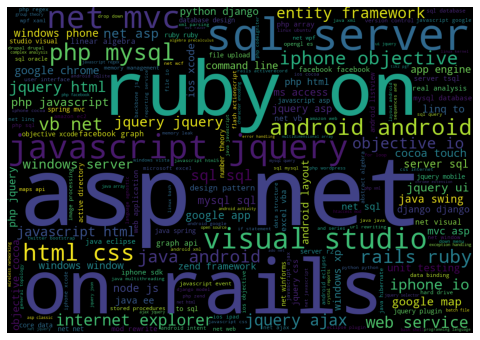

In [ ]:
_plot_wcloud(tags_str)

---
> **This wordcloud looks ambigous. c#, java and many more, the highest occuring tags are dominated by other tags in the word cloud whose occurance is lower than them.**

---
---


In [ ]:
# Top 30 Tag cells by their frequency of occurence

data_no_dup['Tags'].value_counts()[0:30]

android                   35794
php                       21957
jquery                    19842
javascript                17955
javascript jquery         17923
java                      17296
c#                        16318
python                    11920
php mysql                 11501
c++                       11081
mysql                     10792
html css                   9651
iphone                     8603
asp.net                    8105
ruby-on-rails              7060
c# asp.net                 7056
java android               6336
c                          6186
css                        6132
c# .net                    4349
r                          4320
git                        4152
javascript html            4073
iphone objective-c         4071
javascript jquery html     3713
sql                        3686
objective-c                3641
ruby                       3573
mysql sql                  3509
asp.net-mvc                3442
Name: Tags, dtype: int64

---

> **Observe that most occuring tags cell are of word(tag) length 1 and hence label(tag) dependency is something which can be ignored in this data as the tags are fairly independent.**

TBD:
* Include tag count as a feature for each row

---
---

## 3.2 Multivariate Analysis

1. Tags count vs Title Word Count.


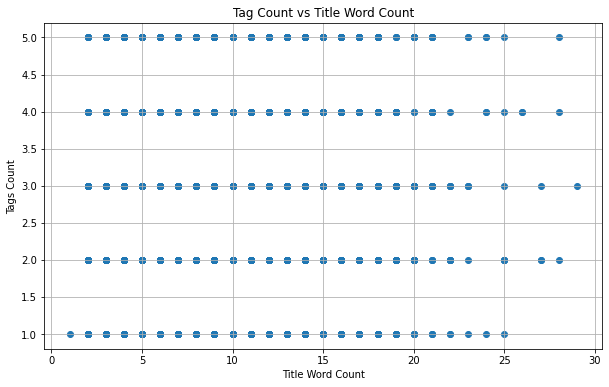

In [ ]:
# Word Count of Title vs tag count on 10K random datapoints

plt.figure(figsize=(10,6))

# Plotting the line points
plt.scatter(title_word_length[:10000], row_tag_count[:10000])

# Defining the labels
plt.xlabel('Title Word Count')
plt.ylabel('Tags Count')

# Defining title
plt.title('Tag Count vs Title Word Count')

# Show legend
#plt.legend()

plt.grid()
plt.show()

---
> **The plot shows no linearity between the two variables. Hence defining 'number of tags' against 'title word count' is useless.**

---
---


# 3 Text Preprocessing

General Tasks:
1. HTML tags Removal
2. Punctuation Removal
3. Stopwords Removal
4. Stemming(This auto lowercases the words) or Lemmitization
5. Convert to Lowercase
7. Expanding Contractions
8. Treat numbers

Specific to this project:
1. Repeat Uppercase Words

TBD: 
1. Not tokenize C#

In [ ]:
# Faster Preprocessing without function calls

datapoints = 500000

def _preprocess(data_unprocessed, type = '', repeat_uppercase = 1):
    """
    Arguments:
    train_list --- A list of unprocessed strings
    type --- 'title' OR 'body'

    Returns:
    filtered_sentences --- A list of processed strings

    TBD : Removal of <code>...</code> in Body
          Not tokenize C#
    """


    stop_words = set(stopwords.words('english'))
    punctuations = '!?$%^&*,:\;_(){}/[].-'      # Note C# has the char '#' and C++ has '+' which should not be ommited
    snow = SnowballStemmer('english')
    filtered_title = []
    filtered_body = []


    if type == 'body' or type == '':
        for i in tqdm(range(len(data_unprocessed))):
            sentence = data_unprocessed['Body'].iloc[i]
            clean = re.compile('<.*?>')
            sentence = re.sub(clean, ' ', sentence).strip() # HTML Removal
            sentence = contractions.fix(sentence)           # Expanding Contractions
            tokens = word_tokenize(sentence)
            temp = ''
            for token in tokens:
                if token not in punctuations and token not in stop_words:           # Punctuation & Stopwords Removal
                    if not token.isnumeric():                                       # Numerals Removal
                        if token.isupper() and token != 'I':                
                            temp += (snow.stem(token) + ' ') * repeat_uppercase     # Stemming and Repeating
                        else:
                            temp += snow.stem(token) + ' '
            filtered_body.append(temp.strip())
        if type == 'body':
            pass # TBD


    if type == 'title' or type == '':
        for i in tqdm(range(len(data_unprocessed))):
            sentence = data_unprocessed['Title'].iloc[i]
            clean = re.compile('<.*?>')
            sentence = re.sub(clean, ' ', sentence).strip() # HTML Removal
            sentence = contractions.fix(sentence)           # Expanding Contractions
            tokens = word_tokenize(sentence)
            temp = ''
            for token in tokens:
                if token not in punctuations:               # Punctuation Removal
                    if token not in stop_words:             # Stopword Removal
                        temp += snow.stem(token) + ' '      # Stemming
            filtered_title.append((temp.strip()))
        if type == 'title':
            data_preprocessed = pd.DataFrame({'Title':filtered_title, 'Tags':data_unprocessed['Tags']})
        else:
            data_preprocessed = pd.DataFrame({'Title':filtered_title, 'Body':filtered_body, 'Tags': data_unprocessed['Tags']})
 

    return data_preprocessed

In [ ]:
# Sanity Check (Driving the above function)

data_preprocessed = _preprocess(data_no_dup[0:500000], type='title')

In [ ]:
# Saving the preprocessed data to CSV file

data_preprocessed.to_csv('/content/gdrive/My Drive/datasets/stacko/preprocessed.csv')

In [ ]:
data_preprocessed = pd.read_csv('/content/gdrive/My Drive/datasets/stacko/preprocessed.csv')

In [ ]:
data_preprocessed.head()

,Unnamed: 0,Title,Tags
0,0,how check upload file imag without mime type,php image-processing file-upload upload mime-t...
1,1,how i prevent firefox close i press ctrl-w,firefox
2,2,r error invalid type list variabl,r matlab machine-learning
3,3,how i replac special charact url,c# url encoding
4,4,how modifi whoi contact detail,php api file-get-contents


In [ ]:
# Preprocessing Functions

"""
def _html_tag_remover(sentence):
    # Ref: https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', sentence).strip()


def _expand_contractions(sentence):
    # Ref: https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
    # Ref: https://pypi.org/project/pycontractions/
    # TBD-- Use spaCy or pycontractions
    return contractions.fix(sentence)


def _punc_remover(sentence):
    punctuations = '!?#$%^&*,:\;-_(){}/[]'
    for character in sentence:
        if character in punctuations:
            sentence = sentence.replace(character, " ")
            continue
    return sentence.strip()


def _stop_remover(sentence):
    # Ref: https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/
    filtered_sentence = ''
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    for token in tokens:
        if token not in stop_words:
            filtered_sentence += token + ' '
    return filtered_sentence.strip()


def _stemmer(sentence): # This automatically converts to lowercase
    stemmed_sentence = ""
    tokens = word_tokenize(sentence) # str.split() can be used for faster result
    # but take a look: https://stackoverflow.com/questions/35345761/python-re-split-vs-nltk-word-tokenize-and-sent-tokenize
    snow = SnowballStemmer('english')
    for token in tokens:
        stemmed_sentence += snow.stem(token) + ' '
    return stemmed_sentence.strip()


def _lemmatizer(sentence):
    pass


def _treat_numbers(sentence):
    pass
"""

# 4 Featurization

1. Data Splitting
2. n-Gram Range
3. Title Weightage

* Vectorizing both Title and Body and merging them later might be more beneficial as this will increase the dimensionality and sparsity of data as opposed to merging first and then vectorizing.
But then, merging them first will enable us to put more weight on the Title part than the Body which could be positive point for the models accuracy.

* The newly derived numerical features should be added as a separate column after vectorization of texts. 

    Why?

    Suppose I build 5 additional features which has values 2,2,2,2,2. If we add these before vectorization to the row, these will be counted as a single feature with a BoW Count of 5! Which is not what we want.

In [ ]:
def _featurize_split_1(data_preprocessed, y_max_features = 75, title_weight = 1, cv_size = 0.2, ngram=(1,1)):
    """
    This function implements merging Title & Body before vectorizing. 
    By Default, only Title will be included and 'Body' will not be considered in vectorization. 
    Uncomment the desired lines in below code.

    Arguments:
    data_preprocessed ---  DataFrame of preprocessed title, preprocessed body and Tags
    y_max_features --- Maximum number of tags to consider based on occurance frequency
    cv_size --- Fraction of input data to split into Cross-Validation set.(default = 0.2)

    Returns:
    X_train --- TfIdf form of each document in the corpus
    X_cv    ---
    y_train --- Binary Bag of Words form of the tags
    y_cv    ---
    """

    merged_train = []
    merged_cv = []


    # Splitting data before transformation to avoid data leakage
    train, cv = train_test_split(data_preprocessed, test_size = cv_size)


    # Count Vectorizer for tags(Output Labels)
    vectorizer_y = CountVectorizer(lowercase=True, binary=True, max_features=y_max_features)
    y_train = vectorizer_y.fit_transform(train['Tags'])              # Binary Bow
    y_cv = vectorizer_y.transform(cv['Tags'])


    # Building a list of number of tags for each row in data
    tag_count_train = []
    tag_count_cv = []
    for each in train['Tags']:
        tag_count_train.append(each.count(' ') + 1)
    for each in cv['Tags']:
        tag_count_cv.append(each.count(' ') + 1)


    # Building a list of word count in each row of Title
    title_word_count_train = []
    title_word_count_cv = []
    for each in train['Title']:
        title_word_count_train.append(each.count(' ') + 1)
    for each in cv['Title']:
        title_word_count_cv.append(each.count(' ') + 1)


    """# Building a list of Word Count in each row of Body
    body_word_count_train = []
    body_word_count_cv = []
    for each in train['Body']:
        body_word_count_train.append(each.count(' ') + 1)
    for each in cv['Body']:
        body_word_count_cv.append(each.count(' ') + 1)"""


    """Merging Title and Body into a single row with weight implemented on Title
    By default, Body has been skipped for frther usage. Uncomment in the below two append lines to
    include body."""
    for i in range(len(train)):
        merged_train.append((train['Title'].iloc[i] + ' ')) # * title_weight  + train['Body'].iloc[i])
    for i in range(len(cv)):
        merged_cv.append((cv['Title'].iloc[i] + ' ')) # * title_weight  + train['Body'].iloc[i])


    # TfIDF Vectorizer for Preprocessed Text
    vectorizer_x = TfidfVectorizer(ngram_range=ngram, max_features=100000)
    X_train = vectorizer_x.fit_transform(merged_train)
    X_cv = vectorizer_x.transform(merged_cv)


    # Merging other derived features to X_train and X_cv
    # pass    # TBD


    # returning in a Dictionary
    return {'X_train':X_train, 'X_cv':X_cv, 'y_train':y_train, 'y_cv':y_cv}

In [ ]:
def _featurize_split_2(data_preprocessed, y_max_features = 75, cv_size = 0.2, ngram=(1,1)):
    """
    This function vectorizes Title and Body separately and later merging them using hstack.

    Arguments:
    data_preprocessed ---  DataFrame of preprocessed title, preprocessed body and Tags
    y_max_features --- Maximum number of tags to consider based on occurance frequency
    cv_size --- Fraction of input data to split into Cross-Validation set.(default = 0.2)

    Returns:
    X_train --- TfIdf form of each document in the corpus
    X_cv    ---
    y_train --- Binary Bag of Words form of the tags
    y_cv    ---
    """

    # Splitting data
    train, cv = train_test_split(data_preprocessed, test_size = cv_size)


    # Count Vectorizer for tags(Output Labels)
    vectorizer = CountVectorizer(lowercase=True, binary=True, max_features=y_max_features)
    y_train = vectorizer.fit_transform(train['Tags'])              # Binary Bow
    y_cv = vectorizer.transform(cv['Tags'])


    # Building a list of number of tags for each row in data
    tag_count_train = []
    tag_count_cv = []
    for each in train['Tags']:
        tag_count_train.append(each.count(' ') + 1)
    for each in cv['Tags']:
        tag_count_cv.append(each.count(' ') + 1)


    # Building a list of word count in each row of Title
    title_word_count_train = []
    title_word_count_cv = []
    for each in train['Title']:
        title_word_count_train.append(each.count(' ') + 1)
    for each in cv['Title']:
        title_word_count_cv.append(each.count(' ') + 1)


    # Building a list of Word Count in each row of Body
    body_word_count_train = []
    body_word_count_cv = []
    for each in train['Body']:
        body_word_count_train.append(each.count(' ') + 1)
    for each in cv['Body']:
        body_word_count_cv.append(each.count(' ') + 1)


    # TfIDF Vectorizer for Preprocessed Title 
    vectorizer_title = TfidfVectorizer(ngram_range = ngram)
    X_train_title = vectorizer_title.fit_transform(train['Title'])
    X_cv_title = vectorizer_title.transform(cv['Title'])


    # TfIDF Vectorizer for Preprocessed Body 
    vectorizer_body = TfidfVectorizer()
    X_train_body = vectorizer_body.fit_transform(train['Body'])
    X_cv_body = vectorizer_body.transform(cv['Body'])


    # Merging the Title and Body Rows
    X_train = hstack((X_train_title, X_train_body))
    X_cv = hstack((X_cv_title, X_cv_body))


    # Merging other derived features to X_train and X_cv
    # pass    # TBD


    # returning in a Dictionary
    return {'X_train':X_train, 'X_cv':X_cv, 'y_train':y_train, 'y_cv':y_cv}

In [ ]:
# Sanity Check (Driving the above function)

data_featurized = _featurize_split_1(data_preprocessed, y_max_features = 700, cv_size = .1, ngram=(1,1))

In [ ]:
data_featurized

{'X_cv': <50000x69966 sparse matrix of type '<class 'numpy.float64'>'
 	with 282468 stored elements in Compressed Sparse Row format>,
 'X_train': <450000x69966 sparse matrix of type '<class 'numpy.float64'>'
 	with 2585576 stored elements in Compressed Sparse Row format>,
 'y_cv': <50000x700 sparse matrix of type '<class 'numpy.int64'>'
 	with 120851 stored elements in Compressed Sparse Row format>,
 'y_train': <450000x700 sparse matrix of type '<class 'numpy.int64'>'
 	with 1088091 stored elements in Compressed Sparse Row format>}

# 5 Model Exploration

We won't go for non-linear models as we will have to train one model for each tag and hence going for the cheaper to train models.

## 5.1 Logistic Regression

1. Data Scaling(Standard Scalar)

In [ ]:
# Logistic Regression function

def _logistic_regression(data_featurized, _alpha=0.0001):
    """
    Arguments:

    Returns:
    """


    scalar = StandardScaler(with_mean=False)
    X_train = scalar.fit_transform(data_featurized['X_train'])
    X_cv = scalar.fit_transform(data_featurized['X_cv'])


    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha = _alpha, n_jobs=-1), n_jobs=-1)
    clf.fit(X_train, data_featurized['y_train'])
    pred = clf.predict(X_cv)
    f1_micro = f1_score(data_featurized['y_cv'], pred, average='micro')
    f1_macro = f1_score(data_featurized['y_cv'], pred, average='macro')
    # acc = accuracy_score(data_featurized['y_cv'], pred)


    print("For alpha = {}, Micro F1 = {:.3f}, Macro F1 = {:.3f}".format(_alpha, f1_micro, f1_macro))

In [ ]:
# Results after model trained on Title with all 4.2M Datapoints and 75 Tags
# Forgot to scale the data :p

for _alpha in [10**i for i in range(-10,-5)]:
    f1, acc = _logistic_regression(X_train, X_cv, y_train, y_cv, _alpha)
    print("For alpha = {}, Micro F1 Score = {} and Accuracy = {}".format(_alpha, f1, acc))

For alpha = 1e-10, Micro F1 Score = 0.5097006600179836 and Accuracy = 0.33132920382805375
For alpha = 1e-09, Micro F1 Score = 0.5573338928861776 and Accuracy = 0.3976770641285781
For alpha = 1e-08, Micro F1 Score = 0.5885593698862491 and Accuracy = 0.4553225329058808
For alpha = 1e-07, Micro F1 Score = 0.5920797712610814 and Accuracy = 0.47235644501184526
For alpha = 1e-06, Micro F1 Score = 0.5726007738904334 and Accuracy = 0.46532535009860176


In [ ]:
# Data Scaling

scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(data_featurized['X_train'])
X_cv = scalar.fit_transform(data_featurized['X_cv'])
y_train = data_featurized['y_train']
y_cv = data_featurized['y_cv']

In [ ]:
# Saving the Scaled Data to Drive for further use

sp.save_npz('/content/gdrive/My Drive/datasets/stacko/x_train', X_train)
sp.save_npz('/content/gdrive/My Drive/datasets/stacko/x_cv', X_cv)
sp.save_npz('/content/gdrive/My Drive/datasets/stacko/y_train', y_train)
sp.save_npz('/content/gdrive/My Drive/datasets/stacko/y_cv', y_cv)

---
We will be purging all the variables on the RAM to free up memory as training 5000 models will consume quite a good amount of RAM and the kernel was killed last time during training due to memory constraints. 
Finally we will load the saved scaled data to start with fresh free memory.

---
---

In [ ]:
# Loading the Scaled data from Drive for training

X_train = sp.load_npz('/content/gdrive/My Drive/datasets/stacko/x_train.npz')
X_cv = sp.load_npz('/content/gdrive/My Drive/datasets/stacko/x_cv.npz')
y_train = sp.load_npz('/content/gdrive/My Drive/datasets/stacko/y_train.npz')
y_cv = sp.load_npz('/content/gdrive/My Drive/datasets/stacko/y_cv.npz')

In [ ]:
# Training OneVSRest Logistic Regression Classifier for 1500 Tags

clf = OneVsRestClassifier(SGDClassifier(loss='log', n_jobs=-1, early_stopping=True, validation_fraction=0.1, verbose=1), n_jobs=-1)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=True, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=-1, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=1,
                                            warm_start=False),
                    n_jobs=-1)

In [ ]:
pred = clf.predict(X_cv)
f1_score(data_featurized['y_cv'], pred, average='macro')

0.3090140757183845

In [ ]:
# Training OneVSRest Logistic Regression Classifier for 700 Tags with default value of alpha

clf = OneVsRestClassifier(SGDClassifier(loss='log', n_jobs=-1, early_stopping=True, validation_fraction=0.1, verbose=1), n_jobs=-1)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=True, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=-1, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=1,
                                            warm_start=False),
                    n_jobs=-1)

In [ ]:
# F1_Score Check

pred = clf.predict(X_cv)
f1_score(y_cv, pred, average='micro')

0.40396652366551794

In [ ]:
# Hyperparameter Tuning: 700 Tags and 500K datapoints

_alpha = [10 ** i for i in range(-10,10,2)]
for al in _alpha:
    clf = OneVsRestClassifier(SGDClassifier(loss='log', n_jobs=-1, early_stopping=True, validation_fraction=0.1, verbose=1, alpha=al), n_jobs=-1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_cv)
    print('For alpha={}, Micro-F1 = {}'.format(al, f1_score(y_cv, pred, average='micro')))

For alpha=1e-10, Micro-F1 = 0.36652845245122795
For alpha=1e-08, Micro-F1 = 0.36864024333908996
For alpha=1e-06, Micro-F1 = 0.3744601740463979
For alpha=0.0001, Micro-F1 = 0.40478360710890643
For alpha=0.01, Micro-F1 = 0.47364108767974483
For alpha=1, Micro-F1 = 0.11057307414287602
For alpha=100, Micro-F1 = 0.009416567891478994
For alpha=10000, Micro-F1 = 0.01839029329649812
For alpha=1000000, Micro-F1 = 0.003008469368045841


---
1. Initial attempt to train on 4.2M datapoints with 75 Output labels was succesful resulting with Micro-F1 Score of 0.59.
2. Tried the same including the 'Body' alongwith the 'Title' but Micro-F1 of 0.04 directed me to ditch and stick to 'Title' only.
3. Next attempts were to train 5k Models for 5000 Tags but had 'Memory Error'.
    * Reduced the TFIDF features to 100K from 240K but still the same error.
    * Now tried with 1M datapoints instead of 4.2M but 'Memory Error' again. 
    * Tried 1500 Models for 1500 Tags this time and it skipped error this time resulting in Micro-F1 of 0.3 without Hyperparameter tuning but took ~1Hour.
    * Gave a final try to train 1500 Models with 4.2M datapoints and it failed again.
4. Trained 700 Models for top 700 tags with 500K datapoints.


---
---

## 5.2 Support Vector Machines

In [ ]:
def _svc(data_featurized):
    """
    Arguments:

    Returns:
    """

    scalar = StandardScaler(with_mean=False)
    X_train = scalar.fit_transform(data_featurized['X_train'])
    X_cv = scalar.fit_transform(data_featurized['X_cv'])

    clf = OneVsRestClassifier(SVC(kernel='rbf'))
    clf.fit(X_train, data_featurized['y_train'])
    pred = clf.predict[X_cv]

    f1_micro = f1_score(data_featurized['y_cv'], pred, average='micro')
    f1_macro = f1_score(data_featurized['y_cv'], pred, average='macro')
    # acc = accuracy_score(data_featurized['y_cv'], pred)
    
    print("Micro F1 = {:.3f}, Macro F1 = {:.3f}".format(f1_micro, f1_macro))

In [ ]:
# Scaling data before Modelling

scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(data_featurized['X_train'])
X_cv = scalar.fit_transform(data_featurized['X_cv'])

In [ ]:
# Training SVC using RBF Kernel with default parameters for top 75 Tags

clf = OneVsRestClassifier(SVC(kernel='rbf'))
clf.fit(X_train, data_featurized['y_train'])

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [ ]:
# Checking F1 Score

pred = clf.predict(X_cv)
f1_score(data_featurized['y_cv'], pred, average='micro')

0.4387215203541734

---
> Although the Micro-F1 score of 0.438 looks decent without hyperparameter tuning, but training only 75 Tags alone took more than **3 Hours** which is very costly.
Hence terminating Model exploration and restricting to only Logistic Regression.

---
---